# Исследование рынка заведений общественного питания Москвы

Цель проекта - исследование рынка общественного питания в Москве. Необходимо понять, сможет ли стартап - маленькое кафе, обслуживаемое роботами - стать прибыльным в долгосрочной перспективе

В проекте используются данные о заведениях общественного питания Москвы (за какой период не указано). Данные не панельные, поэтому отследить ситуацию во времени мы не сможем. Сможем описать текущее положение дел

**Подготовка данных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests 
from scipy import stats

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропущенных данных нет. Все атрибуты имеют корректный тип данных

In [4]:
rest_data.duplicated().sum()

0

Дубликатов в таблице нет

In [5]:
display(rest_data.head(5))

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


**Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график**

In [6]:
object_type = rest_data.groupby('object_type')['id'].count().sort_values(ascending=False).reset_index()

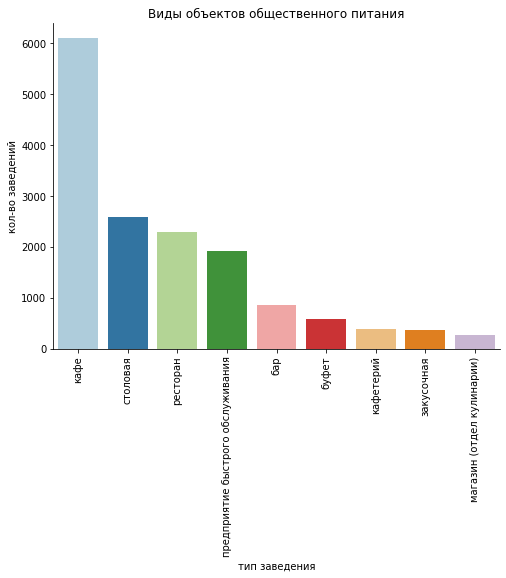

In [7]:
plt.figure(figsize=(8, 6))
sns.barplot(x='object_type', y='id', 
              data=object_type, palette="Paired")
sns.set_style("ticks") 
sns.despine()
plt.xlabel('тип заведения')
plt.ylabel('кол-во заведений')
plt.xticks(rotation=90)
plt.title('Виды объектов общественного питания'); 

На первом месте по количеству заведений столовые и кафе. На последнем кафетерии, закусочные и отделы кулинарии в магазинах

**Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график**

In [8]:
n_chain = rest_data.groupby('chain')['id'].count().sort_values(ascending=False).reset_index()
n_chain 

,chain,id
0,нет,12398
1,да,2968


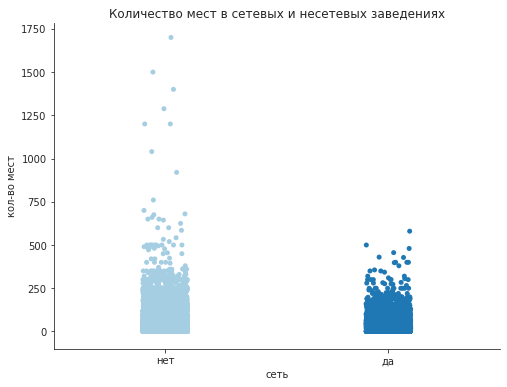

In [9]:
plt.figure(figsize=(8, 6))
sns.stripplot(x='chain', y='number', 
              data=rest_data, palette="Paired")
sns.set_style("ticks") 
sns.despine()
plt.xlabel('сеть')
plt.ylabel('кол-во мест')
plt.title('Количество мест в сетевых и несетевых заведениях'); 

Среди заведений общественного питания больше несетевых. В несетвых так же больше мест в среднем, чем в сетевых заведениях

**Для какого вида объекта общественного питания характерно сетевое распространение?**

In [10]:
object_type = rest_data.groupby(['object_type', 'chain'])['id'].count().sort_values(ascending=False).reset_index()

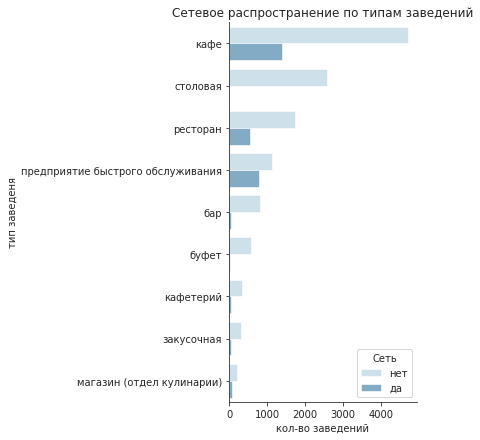

In [11]:
sns.catplot(
    data=object_type, kind="bar",
    x="id", y="object_type", hue="chain",
    ci="sd", palette="Paired", alpha=.6, height=6, legend_out = False)
sns.set_style("ticks") 
sns.despine()
plt.xlabel('кол-во заведений')
plt.ylabel('тип заведеня')
plt.legend(title='Сеть', loc='lower right')
plt.title('Сетевое распространение по типам заведений');

Больше всего сетевых заведений среди кафе и предприятий быстрого обслуживания

**Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?**

In [12]:
rest = rest_data[rest_data['chain']=='да'].pivot_table(values=['number','id'], index='object_name', 
                                                aggfunc={'number': 'mean', 'id':'count'}).reset_index()

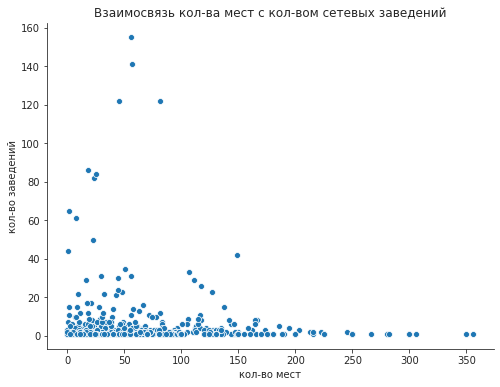

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(y='id', x='number', data=rest)
sns.set_style("ticks") 
sns.despine() 
plt.xlabel('кол-во мест')
plt.ylabel('кол-во заведений')
plt.title('Взаимосвязь кол-ва мест с кол-вом сетевых заведений');

In [14]:
pearson_coef, p_value = stats.pearsonr(rest["id"], rest["number"])
print("Коэффициент корреляции Пирсона: ", pearson_coef)
print("p-value:", p_value)  

Коэффициент корреляции Пирсона:  -0.04286790933691214
p-value: 0.24932353517188918


По графику можно сказать, что маленькое количество завдедений с большим количеством мест и большое количество заведений с маленьким количеством мест - исключения. Самое большое количество наблюдений сконцентрировано в левом нижнем углу графика. Для небольшого количества заведений (3-5) среднее количество посадочных мест может быть разным (видим большую концентрацию точек вдоль одной прямой с количеством заведений). Коэффициент корреляции Пирсона маленький и статистически незначимый на уровне значимости 0.05. Это также свидетельствует о том, что линейной связи между количеством мест и заведений у сети нет.

**Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики**

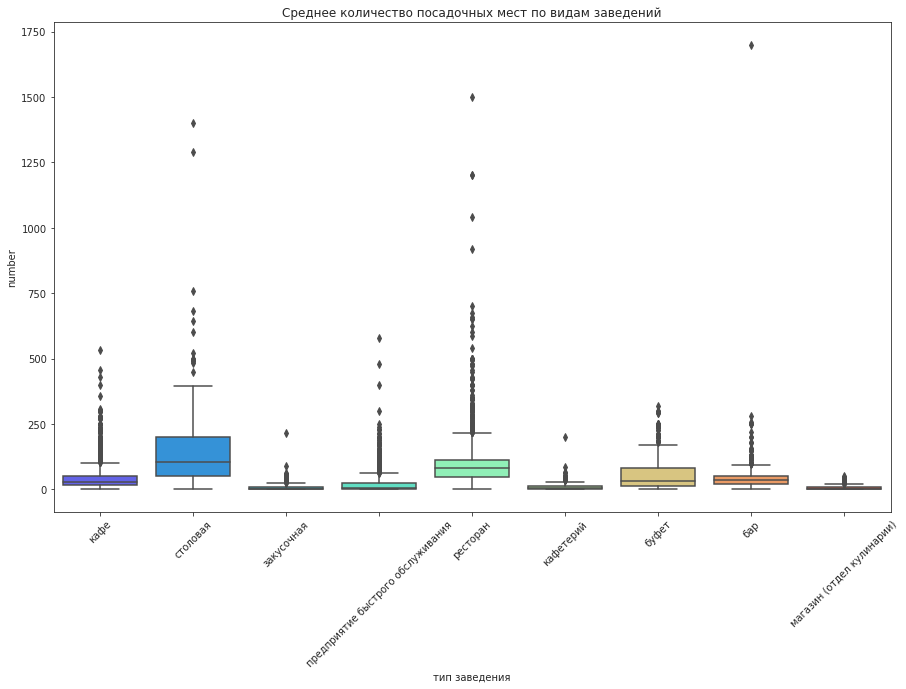

In [15]:
plt.figure(figsize=(15, 9))
sns.boxplot(x="object_type", y="number", data=rest_data, palette='rainbow').set_title('Среднее количество посадочных мест по видам заведений')
sns.color_palette("Set2")
plt.xlabel('тип заведения')
plt.xticks(rotation=45); 

"Ящики с усами" позволяют увидеть, что больше всего посадочных мест предоставляют столовые и рестораны (смотрим на линию медианы). Для ресторанов характерно много выбросов в большую сторону

In [16]:
rest_data.groupby('object_type')['number'].mean()

object_type
бар                                   43.494159
буфет                                 51.129915
закусочная                             7.608333
кафе                                  39.716019
кафетерий                              9.123116
магазин (отдел кулинарии)              5.589744
предприятие быстрого обслуживания     20.552262
ресторан                              96.834136
столовая                             130.246618
Name: number, dtype: float64

Больше всего посадочных мест в среднем предоставляют столовые

**Выделите в отдельный столбец информацию об улице из столбца address**

In [17]:
f = lambda x: x['address'].split(sep=',')[1]
rest_data['street'] = rest_data.apply(f, axis=1)

**Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?**

In [18]:
top10streets = rest_data.groupby(['street'])['id'].count().sort_values(ascending=False).head(12).reset_index()
top10streets

top10streets = top10streets.drop(top10streets.index [0]) 
top10streets = top10streets.drop(top10streets.index [6])
top10streets = top10streets.reset_index()

top10streets = top10streets[['street', 'id']]

В список улиц попали Зеленоград и поселение Сосенское. Нужно удалить их из списка, так как эти административные единицы нельзя назвать улицами

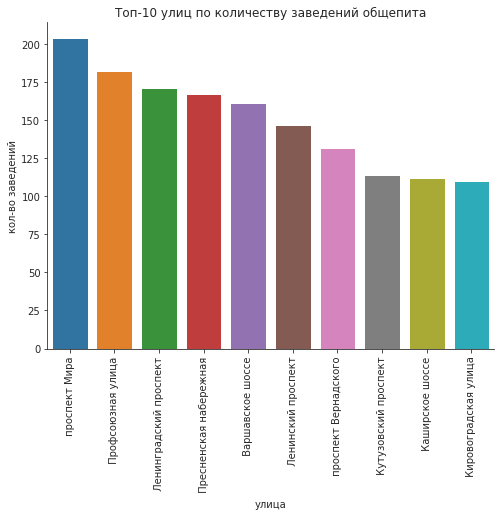

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(x='street', y='id', data=top10streets)
sns.set_style("ticks") 
sns.despine()
plt.xlabel('улица')
plt.ylabel('кол-во заведений')
plt.xticks(rotation=90)
plt.title('Топ-10 улиц по количеству заведений общепита'); 

Теперь к каждой улице нужно проставить район, в котором эта улица находится. Для этого я использую информацию с внешнего сайти

In [20]:
#Сайт со списком улиц, округов и районов
URL = 'http://xn----7sbbj7ab0abgod6a9h.xn--80adxhks/%D0%B2%D1%81%D0%B5_%D1%83%D0%BB%D0%B8%D1%86%D1%8B_%D0%BC%D0%BE%D1%81%D0%BA%D0%B2%D1%8B?'

In [21]:
PARAM={"page": "1"}
req = requests.get(url = URL, params = PARAM) 

In [22]:
from bs4 import BeautifulSoup
soup=BeautifulSoup(req.text, 'lxml') 

In [23]:
table = soup.find("table")

In [24]:
heading_table = [] 
for row in table.find_all('th'):
        heading_table.append(row.text) 

In [25]:
content=[] 
num_of_page = 309

for i in range(1, num_of_page+1): 
    r = requests.get(URL, {'page': str(i)})  
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find("table")
    for row in table.find_all('tr'): 
        if not row.find_all('th'): 
            content.append([element.text for element in row.find_all('td')])

In [26]:
moscow = pd.DataFrame(content, columns=heading_table) 

In [27]:
moscow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6488 entries, 0 to 6487
Data columns (total 5 columns):
Наименование              6488 non-null object
Тип                       6488 non-null object
Индекс                    6488 non-null object
Административный округ    6488 non-null object
Район                     6488 non-null object
dtypes: object(5)
memory usage: 253.6+ KB


In [28]:
moscow = moscow[['Наименование', 'Тип', 'Район', 'Административный округ']]
moscow.rename(columns={'Наименование': 'street', 'Тип': 'type', 'Район': 'district', 'Административный округ':'okrug'}, inplace=True)

In [29]:
moscow = moscow[moscow['street']!='']

In [30]:
moscow = moscow.drop_duplicates().reset_index(drop = True)

In [31]:
display(moscow.head(5))

,street,type,district,okrug
0,1,мкр,Десёновское поселение,Новомосковский административный округ
1,1 Маевки,аллея,район Вешняки,Восточный административный округ
2,1 Мая,ул,район Крюково,Зеленоградский административный округ
3,1-й,мкр,Внуковское поселение,Новомосковский административный округ
4,1-й,пр-кт,район Ивановское,Восточный административный округ


In [32]:
moscow['street2'] = moscow.apply(lambda x: x['street'].replace(' ',''), axis=1)

In [33]:
moscow['type'].unique()

array(['мкр', 'аллея', 'ул', 'пр-кт', 'проезд', 'пер', 'просек', 'кв-л',
       'туп', 'линия', 'ш', 'пл', 'просека', 'б-р', 'наб', 'ст', 'км',
       'тер', 'гск', 'стр', 'парк', 'п', 'д', 'нп', 'городок', 'дор',
       'проселок', 'снт', 'платф', 'х'], dtype=object)

In [34]:
street_types = ['улица','проспект','проезд','переулок','площадь','линия','набережная','тупик','бульвар',
'шоссе','аллея']
types_short = ['ул','пр-кт','проезд','пер','пл','линия','наб','ту','б-р',
'шоссе','аллея']

In [35]:
a=[]
for i in top10streets['street']:
    for word in street_types:
        if word in i:
            a.append(word)
top10streets['street_types'] = a

In [36]:
types = pd.DataFrame({'street_types':['шоссе', 'улица','проспект','проезд','переулок','площадь','линия','набережная','тупик','бульвар',
'шоссе','аллея', 'просек'], 'types':['ш', 'ул','пр-кт','проезд','пер','пл','линия','наб','ту','б-р',
'шоссе','аллея','просек']})

In [37]:
top10streets = top10streets.merge(types, on='street_types', how='left')

In [38]:
b = []
for i in top10streets['street']:
    for word in street_types:
        if word in i:
            b.append(i.replace(word,''))
            
top10streets['street_short'] = b
top10streets['street2'] = top10streets.apply(lambda x: x['street_short'].replace(' ',''), axis=1)

In [39]:
top10withdistricts = top10streets.merge(moscow, left_on=['street2','types'], right_on=['street2','type'], how='inner')

In [40]:
top10withdistricts = top10withdistricts[['street_x', 'district', 'okrug']]
top10withdistricts.rename(columns={'street_x': 'street'}, inplace=True)

In [41]:
display(top10withdistricts)

,street,district,okrug
0,проспект Мира,Алексеевский район,Северо-Восточный административный округ
1,Профсоюзная улица,Рязановское поселение,Новомосковский административный округ
2,Профсоюзная улица,район Коньково,Юго-Западный административный округ
3,Ленинградский проспект,Хорошевский район,Северный административный округ
4,Пресненская набережная,Пресненский район,Центральный административный округ
5,Варшавское шоссе,район Чертаново Центральное,Южный административный округ
6,Ленинский проспект,Ломоносовский район,Юго-Западный административный округ
7,проспект Вернадского,Ломоносовский район,Юго-Западный административный округ
8,Кутузовский проспект,район Дорогомилово,Западный административный округ
9,Каширское шоссе,район Москворечье-Сабурово,Южный административный округ


По районам видим, что большая концентрация кафе сосредоточена не только в центре Москвы (исключение - Пресненская набережная). Вообще есть ощущение, что большое количество кафе характерно для южных районов Москвы. Улица Профсоюзная относится к двум районам, судя по информации из справочника, который я запарсила

**Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?**

In [42]:
streets_with1 = rest_data.groupby(['street'])['id'].count().sort_values(ascending=False).reset_index()

In [43]:
streets_with1 = streets_with1[streets_with1['id']==1].reset_index()
streets_with1.shape[0]

579

Найдено 579 улиц с одним заведением общественного питания

In [44]:
n=[]
pattern = 'улица|шоссе|набережная|проспект|проезд|переулок|площадь|линия|тупик|бульвар|аллея|просек'
for i in streets_with1['street']:
    n.append(re.findall(pattern, i))
    #print(re.findall(pattern, i))
#streets_with1['street_type'] =n
#n
n = list(map(''.join, n))
streets_with1['street_types'] =n

In [45]:
m=[]
pattern = 'улица|шоссе|набережная|проспект|проезд|переулок|площадь|линия|тупик|бульвар|аллея|просек'
for i in streets_with1['street']:
    m.append(re.sub(pattern, '', i))
m = list(map(''.join, m))
streets_with1['street_short'] =m
f6 = lambda x: x['street2'].replace(' ','')
streets_with1['street_short'] = streets_with1.apply(lambda x: x['street_short'].replace(' ',''), axis=1)

In [46]:
streets_with1 = streets_with1.merge(types, on='street_types', how='inner')

In [47]:
streets_with1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 532
Data columns (total 6 columns):
index           533 non-null int64
street          533 non-null object
id              533 non-null int64
street_types    533 non-null object
street_short    533 non-null object
types           533 non-null object
dtypes: int64(2), object(4)
memory usage: 29.1+ KB


In [48]:
streets_with1district = streets_with1.merge(moscow, left_on=['street_short', 'types'], right_on=['street2','type'], how='left')

In [49]:
streets_with1district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568 entries, 0 to 567
Data columns (total 11 columns):
index           568 non-null int64
street_x        568 non-null object
id              568 non-null int64
street_types    568 non-null object
street_short    568 non-null object
types           568 non-null object
street_y        545 non-null object
type            545 non-null object
district        545 non-null object
okrug           545 non-null object
street2         545 non-null object
dtypes: int64(2), object(9)
memory usage: 53.2+ KB


В итоговой таблице получилось больше строк, чем в исходной, потому что одна улица может принадлежать нескольким районам

In [50]:
streets_with1district = streets_with1district[['street_x', 'district', 'okrug']]
streets_with1district.rename(columns={'street_x': 'street'}, inplace=True)

In [51]:
display(streets_with1district.head(10))

,street,district,okrug
0,улица Алексея Дикого,район Новогиреево,Восточный административный округ
1,8-я улица Соколиной Горы,район Соколиная Гора,Восточный административный округ
2,6-я улица Лазенки,район Ново-Переделкино,Западный административный округ
3,улица Благуша,район Соколиная Гора,Восточный административный округ
4,улица Атарбекова,район Преображенское,Восточный административный округ
5,улица Анатолия Живова,Пресненский район,Центральный административный округ
6,6-я Кожуховская улица,Южнопортовый район,Юго-Восточный административный округ
7,улица Богородский Вал,район Преображенское,Восточный административный округ
8,улица Павла Андреева,Даниловский район,Южный административный округ
9,6-я улица Новые Сады,район Ново-Переделкино,Западный административный округ


In [52]:
streets_with1district.groupby('district')['street'].count().sort_values(ascending=False).head(10)

district
Таганский район        25
район Хамовники        23
Басманный район        22
Тверской район         20
Пресненский район      17
район Марьина роща     17
Мещанский район        15
район Сокольники       14
район Замоскворечье    13
район Арбат            12
Name: street, dtype: int64

Я выбрала топ-10 районов, в которых больше всего улиц с одним заведением общественного питания. Результат меня немного удивляет, так как кажется, что на всех улицах центральных или многолюдных районов всегда много кафе

In [53]:
streets_with1district[streets_with1district['district']=='район Арбат']

,street,district,okrug
123,Композиторская улица,район Арбат,Центральный административный округ
305,1-й Николощеповский переулок,район Арбат,Центральный административный округ
326,Калошин переулок,район Арбат,Центральный административный округ
327,Проточный переулок,район Арбат,Центральный административный округ
350,Малый Николопесковский переулок,район Арбат,Центральный административный округ
364,Кривоарбатский переулок,район Арбат,Центральный административный округ
375,Шубинский переулок,район Арбат,Центральный административный округ
383,Филипповский переулок,район Арбат,Центральный административный округ
390,Большой Афанасьевский переулок,район Арбат,Центральный административный округ
397,Большой Николопесковский переулок,район Арбат,Центральный административный округ


На примере Арбата видим, что в перечень вошли маленькие переулки. Логично, что на таких маленьких улочках можно встретить одно заведение

**Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?**

Отбираю топ-10 улиц (ориентируюсь на предыдущий пункт задания), чтобы посмотреть разброс по посадочным местам

In [54]:
places = rest_data[rest_data['street'].isin([' проспект Мира', ' Профсоюзная улица', 'Ленинградский проспект ', 'Пресненская набережная ', 'Варшавское шоссе ', 'Ленинский проспект ', 'проспект Вернадского ', 'Кутузовский проспект ', 'Каширское шоссе ', 'Кировоградская улица '])]

Смотрю на распределение количества мест на этих улицах

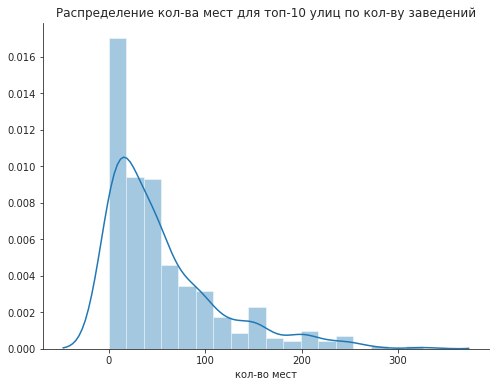

In [55]:
plt.figure(figsize=(8, 6))
sns.distplot(places['number'])
sns.set_style("ticks") 
sns.despine() 
plt.xlabel('кол-во мест')
plt.title('Распределение кол-ва мест для топ-10 улиц по кол-ву заведений'); 

Распределение скошено вправо. На улицах с самым большим количеством заведений общественного питания, количество посадочных мест чаще всего не превышает 20. Медиана равна 40 - это подтверждает наше предположение о том, что количество мест небольшое

In [56]:
places['number'].median()

40.0

**Основные выводы:**
- По количеству заведений лидируют столовые и кафе
- Несетевых заведений больше, чем сетевых. Количество мест в несетевых тоже в среднем больше, чем в сетевых
- Больше всего сетевых заведений среди кафе и предприятий быстрого обслуживания
- Связи между количеством заведений сети и количеством мест нет
- Больше всего посадочных мест в среднем предоставляют столовые
- Большое количество кафе характерно для южных районов Москвы
- В центральных районах Москвы больше всего улиц с 1 заведением общественного питания
- На улицах с самым большим количеством заведений общественного питания, количество посадочных мест чаще всего не превышает 20

**Рекомендации:**
- Нужно ориентироваться на центр и южные районы Москвы, где заведения общепита популярны
- Упор нужно сделать на скорость обслуживания (роботы как более быстрый способ получить еду). Если сделать упор на роботов самих по себе, то есть риск, что ажиотаж вокруг заведения быстро пропадёт
- Нужно сделать упор на выстраивание сети со средним количеством посадочных мест (самые популярные заведения)
- Нужно провести качественное исследование (например, фокус-группы), чтобы понять, какие потребности есть у посетителей заведений общепита и оценить их готовность к нововведениям в целом